# Eco-evolutionary dynamics in agriculture: a study in crop rotations

### Packages

In [1]:
#!/usr/bin/env python

from __future__ import division
from subprocess import call
from scipy import *
from scipy.linalg import eigh as largest_eigh
from scipy.integrate import odeint
import scipy.integrate as spi
import numpy as np
from itertools import combinations
from itertools import repeat
import matplotlib.pyplot as plt
import math
import io
import csv
import sys, os
import pandas as pd
from pylab import *

### Parameters

In [2]:
## For crop rotation cash yield and soil quality

q0 = 1 # init soil quality
y0 = 0 # init cash yield
K = 2 #carrying capacity
beta_h1 = -1.5  #soil contribution h1
beta_h1_r = -1.5 #soil contribution h1_r
beta_h2 = 1 #soil contribution h2
y_h1 = 1 #cash contribution h1
y_h1_r = 0.9 #cash contribution h1_r
y_h2 = 0 #cash contribution h2



## For eco-evo dynamics
epsilon = 0.5 # pathogen clearance
k = 0.1 # cost of resistance
mu = 0.1 # transition probability
a = 0.5 # GfG proportion
sigma = 0.04 # pathogen virulence of p1
H_dens = 50 # host density
dp = 0.5 # pathogen deathrate



## Time (needed for simulation)
t_step = 0.005
t_last = int(1/t_step)

### Infection environment (pathogen yes/no, time of infection)

In [3]:
pathogen_true = 1 # int(raw_input("pathogen true? 1 = true, 0 = false")) #presence or absence of pathogen
infection_time = 0 #int(raw_input("infection time?")) # time the pathogen infects


pathogen true? 1 = true, 0 = false1
infection time?0


### Sequence population (create all possible patterns of a certain length)

In [4]:
num_seq = 1
l = 10  #length
#write your sequence of interest, as a combination of h1, h2 and h1_r of length l
seq = ['h2','h2','h2','h1','h2','h1','h2','h1','h1','h1']

In [5]:
## binary sequence for each crop type

def get_h_seq(seq):
    crop_types = ['h1','h2','hr']
    seq_elements = seq
    binaries = {k:[int(k in v) for v in seq_elements]for k in crop_types}
    h1_seq,h2_seq,hr_seq = binaries['h1'],binaries['h2'],binaries['hr']
    
    return h1_seq,h2_seq,hr_seq

h1_seq,h2_seq,hr_seq = get_h_seq(seq)

### Transition and fitness matrices (section 2.2)

In [6]:
def transition_matrix():
    d = np.array([
    [1 - 2*mu ,mu,0,0,0,mu,0,0,0,0],
    [mu,1 - 3*mu,mu,0,0,0,mu,0,0,0],
    [0,mu,1 - 3*mu,mu,0,0,0,mu,0,0],
    [0,0,mu,1 - 3*mu,mu,0,0,0,mu,0],
    [0,0,0,mu,1 - 2*mu,0,0,0,0,mu],
    [mu,0,0,0,0,1 - 2*mu,mu,0,0,0],
    [0,mu,0,0,0,mu,1 - 3*mu,mu,0,0],
    [0,0,mu,0,0,0,mu,1 - 3*mu,mu,0],
    [0,0,0,mu,0,0,0,mu,1 - 3*mu,mu],
    [0,0,0,0,mu,0,0,0,mu,1 - 2*mu]
    ])
    # d = np.identity(10) ### in case we don't want any transition between types
    return(d)

q_matrix = transition_matrix()

In [7]:
def fitness_matrix():
    w_matrix = np.array([[1,0,0],[1.25,0,0],[1.5,0,0],[1.75,0,0],[2,0,0],
    [a*(1 - a*k),1 - a*k,0],[a*(1.25 - a*k),1.25 - a*k,0],[a*(1.5 - a*k),1.5 - a*k,0],[a*(1.75 - a*k),1.75 - a*k,0],
    [a*(2 - a*k),2 - a*k,0]])

    return(w_matrix)

w_matrix = fitness_matrix()


### Eco-Evo dynamics (section 2.2)

In [8]:
def infection(h1_seq,hr_seq,h2_seq):
    def HP_evol(t,init): ## equations for host-pathogen coevolution
        h = np.array(init[0:3],dtype='float16')
        p = np.array(init[3:13],dtype='float16')
        hdot = np.zeros(3)
        pdot = np.zeros(10)
        
        for h_type in range(0,3):    
            hdot[h_type] = h[h_type] * np.sum((-sigma * np.multiply(w_matrix[:,h_type], p,dtype='float16')))

        for p_type in range(0,10):
            pdot[p_type] = np.sum((np.multiply(q_matrix[:,p_type], p,dtype='float16') * np.sum((sigma * np.multiply(w_matrix[p_type,:], h,dtype='float16'))))) - p[p_type]*dp
        
        ydot = np.append(hdot,pdot)
        return(ydot)
    
    
    t_i = 0 #init time (start of season)
    t_f = 1 #final time (end of season)
    general_ts = []
    general_zs = []
    z0 = np.zeros(13)
    for i in range(0,l):

      h1 = H_dens * (h1_seq[i])
      hr = H_dens * (hr_seq[i])
      h2 = H_dens * (h2_seq[i])
      
      z0[0:3] = [h1,hr,h2]

      if t_i == infection_time and pathogen_true == 1: ## introducing the pathogen at infection time with a density of 1
        p1 = 1
        z0[3] = p1

      ## ODE solver
    
      t_end = 1
      t_start = 0.
      t_step = 0.005
      t_interval = np.arange(t_start, t_end, t_step)

      myode =  spi.ode(HP_evol)
      myode.set_integrator('lsoda',nsteps = 500000000)
      myode.set_initial_value(z0,t_start)

      ts = [0]
      zs = [z0]  

      while myode.successful() and myode.t < t_end:
         myode.integrate(myode.t + t_step)
         ts.append(myode.t)
         zs.append(myode.y)

      z_final = zs[t_last]
      #
      h1_f = z_final[0]
      h1_r_f = z_final[1]
      h2_f = z_final[2]
      
      p = np.zeros(10)
      for n in range(0,10):
        p[n] = epsilon * z_final[(n + 3)]
      
      z0[3:13] = p
  
      t_extra = np.full((t_last + 1,),i)
      general_ts.append(ts + t_extra)
      general_zs.append(zs)

      t_i = t_i + 1  #discrete time increase
      t_f = t_f + 1
    return general_ts,general_zs

ts,zs = infection(h1_seq,hr_seq,h2_seq)



### Soil quality and cash yield in crop rotation patterns (section 2.1 and 2.3)

In [9]:
def getdeltas(seq,zs):  ## section 2.3, delta as the ratio of host at the end of season and initial host density
    zs = np.array(zs)
    zz = zs[:,t_last]
    zz_all = []
    for j in range(0,l):
        zz_1 = zz[j]
        zz_2 = zz_1[0:3]
        zz_all.append(zz_2)
    zz_all = np.array(zz_all)
    x = np.sum(zz_all,axis = 1)    
    deltas = x/H_dens 
    return deltas


deltas = getdeltas(seq,zs)


def fitness_function(init_cash,init_soil,seq,deltas):

    soil_vector = []
    cash_vector = []
    n_h2 = 0 #n of consecutive cover crops
    n_h1_hr = 0 #n of consecutive cash crops
    
    
    soil_seq = np.zeros(l + 1) #vector that will have soil changes
    soil_seq[0] = init_soil

    cash_seq = np.zeros(l + 1) #vector that will have cash changes
    cash_seq[0] = init_cash

    for t in range(0,l):
        d = deltas[t]      
        if seq[t] == 'h2': #soil quality and cash yield for cv crops
            n_h2 = n_h2 + 1
            n_h1_hr = 0
            soil_seq[t + 1] = max(0.01, min(1.99,((K * soil_seq[t] * math.exp(beta_h2)) / (K + soil_seq[t] * (math.exp(beta_h2) - 1)))))
            cash_seq[t + 1] = cash_seq[t] + y_h2 * d * soil_seq[t]
        elif seq[t]=='h1': 
            n_h1_hr = n_h1_hr + 1
            n_h2 = 0
            soil_seq[t + 1] = max(0.01, min(1.99,((K * soil_seq[t] * math.exp(beta_h1)) / (K + soil_seq[t] * (math.exp(beta_h1) - 1)))))
            cash_seq[t + 1] = cash_seq[t] + y_h1 * d * soil_seq[t]
        elif seq[t]=='hr': 
            n_h1_hr = n_h1_hr + 1
            n_h2 = 0
            soil_seq[t + 1] = max(0.01, min(1.99,((K * soil_seq[t] * math.exp(beta_hr)) / (K + soil_seq[t] * (math.exp(beta_hr) - 1)))))
            cash_seq[t + 1] = cash_seq[t] + y_hr * d * soil_seq[t]
    
    fitness = cash_seq[l]
    return cash_seq,soil_seq,fitness


init_soil = np.full(1,q0)    #init soil is 1
init_cash = np.full(1,y0)   #init cash is 0

cash_seq,soil_seq,fitness = fitness_function(init_cash,init_soil,seq,deltas)

print("cash", cash_seq)
print("soil", soil_seq)
print("fitness",fitness)

('cash', array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.90023504,
        1.90023504,  3.74491629,  3.74491629,  5.50323875,  6.73805887,
        7.25029433]))
('soil', array([ 1.        ,  1.46211716,  1.76159416,  1.90514825,  1.63514895,
        1.84828364,  1.46211716,  1.76159416,  1.24491866,  0.53788284,
        0.15171636]))
('fitness', 7.2502943323471634)


### Plots

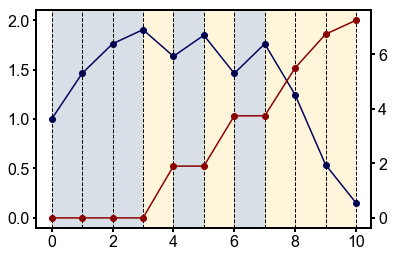

In [10]:
## soil quality and cash yield
# soil quality and cash yield

t_sc = np.linspace(0,l,l+1)
fig2,ax = plt.subplots()
plt.xticks(fontname = "Arial")
plt.yticks(fontname = "Arial")
plt.tick_params(labelsize=16)

ax2 = ax.twinx()
ax2.plot(t_sc,np.array(cash_seq).T,color='darkred',marker='o')
ax.plot(t_sc,(np.array(soil_seq).T),color ='xkcd:dark blue',marker='o')
for i in range(0,l):
    ax.axvline(i,linestyle = '--', lw = 1, c = 'xkcd:black')
    if seq[i] == 'h1':
        ax.axvspan(i,i+1,facecolor = 'xkcd:golden rod', alpha = 0.15)
    if seq[i] == 'h2':
        ax.axvspan(i,i+1,facecolor = 'xkcd:marine', alpha = 0.15)
ax.axvline(l,linestyle = '--', lw = 1, c = 'xkcd:black')

#ax2.set_ylim((-0.4,8.4))
ax.set_ylim((-0.1,2.1))
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax2.yaxis.set_tick_params(width=2)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
plt.yticks(fontname = "Arial")

plt.tick_params(labelsize=16)
plt.show()



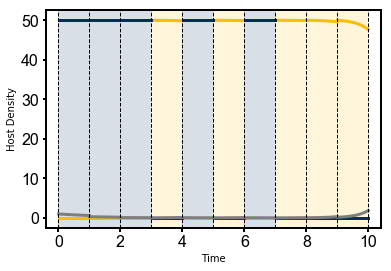

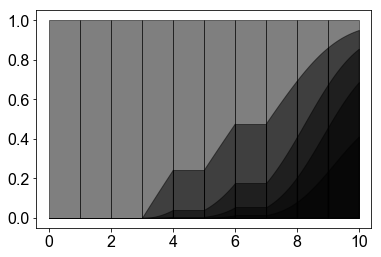

In [13]:
## eco evo dynamics


t3 = np.vstack(ts).T
y = np.array(zs).T

y = y[:,1:,:]
t3 = t3[1:,:]

h1,h1_r,h2,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10 = y


p_sum = p1 + p2 + p3 + p4 + p5


fig,ax = plt.subplots()

plt.yticks(fontname = "Arial")
plt.xticks(fontname = "Arial")
plt.tick_params(labelsize=16)

ax.plot(t3,h1,label='h1',color='xkcd:golden rod',lw =3)
ax.plot(t3,h2,label='h2',color='xkcd:marine',lw = 3)

ax.plot(t3,p_sum,label='p sum',color='xkcd:medium grey',lw = 3)

ax.set_xlabel('Time')
ax.set_ylabel('Host Density')
ax.set_xlim((-0.4,l + 0.4))

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)

for i in range(0,l):
     ax.axvline(i,linestyle = '--', lw = 1, c = 'xkcd:black')
     if seq[i] == 'h1':
         ax.axvspan(i,i+1,facecolor = 'xkcd:golden rod', alpha = 0.15)
     if seq[i] == 'h2':
         ax.axvspan(i,i+1,facecolor = 'xkcd:marine', alpha = 0.15)
ax.axvline(l,linestyle = '--', lw = 1, c = 'xkcd:black')

plt.show()



freq_p5 = p5 / p_sum
freq_p4 = p4 / p_sum
freq_p3 = p3 / p_sum
freq_p2 = p2 / p_sum
freq_p1 = p1 / p_sum

freq_min = np.zeros((np.shape(freq_p5)))
freq_min_a = np.zeros(200*l)

freq_p5_a = freq_p5.reshape(-1)

t3_a = t3.reshape(-1)

#
fig,ax = plt.subplots()
#
plt.yticks(fontname = "Arial")
plt.xticks(fontname = "Arial")
plt.tick_params(labelsize=16)

for i in range(0,l):
    ax.fill_between(t3[:,i], freq_p5[:,i] + freq_p4[:,i] + freq_p3[:,i] + freq_p2[:,i] + freq_p1[:,i],freq_min[:,i],label='p sum',color='xkcd:black',alpha = 0.5)
    ax.fill_between(t3[:,i], freq_p5[:,i] + freq_p4[:,i] + freq_p3[:,i] + freq_p2[:,i],freq_min[:,i],label='p sum',color='xkcd:black',alpha = 0.5)
    ax.fill_between(t3[:,i], freq_p5[:,i] + freq_p4[:,i] + freq_p3[:,i],freq_min[:,i],label='p sum',color='xkcd:black',alpha = 0.5)
    ax.fill_between(t3[:,i], freq_p5[:,i] + freq_p4[:,i],freq_min[:,i],label='p sum',color='xkcd:black',alpha = 0.5)
    ax.fill_between(t3[:,i], freq_p5[:,i],freq_min[:,i],label='p sum',color='xkcd:black',alpha = 0.5)

ax.set_xlim((-0.4,l + 0.4))

plt.show()

